# GrIS ablation zone melt SEB causality

Author: Ziqi Yin

Last modified: 2025 Aug 7

Description: comparing causal graphs from RACMO, MAR, and CESM2 LENS2 during the historical period (1940-1969), and comparing LENS2 graph during the historical period with future scenario (2071-2100)

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import sys
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
from copy import deepcopy

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb

import cartopy
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PolyCollection
from collections import Counter, defaultdict

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

## Read data

### Causal graph

In [3]:
## Set parameters
max_lag = 12
pc_alpha = 0.1

In [4]:
## RACMO
# 1940-1969
data_dir = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(max_lag)+'_alpha'+str(pc_alpha)+'_clean_forplot.npz'

data = np.load(data_dir, allow_pickle=True)
val_matrix_RACMO_his = data['val_matrix']
graph_RACMO_his = data['graph']
link_width_RACMO_his = data['link_width']
var_names_RACMO_his = data['var_names'].tolist()

In [5]:
## MAR
# 1940-1969
data_dir = home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(max_lag)+'_alpha'+str(pc_alpha)+'_clean_forplot.npz'

data = np.load(data_dir, allow_pickle=True)
val_matrix_MAR_his = data['val_matrix']
graph_MAR_his = data['graph']
link_width_MAR_his = data['link_width']
var_names_MAR_his = data['var_names'].tolist()

In [6]:
## LENS2
# 1940-1969
data_dir = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BHIST_realJJA_GrIS_ablation_noseasonality_LENS2_1940_1969_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig_forplot.npz'

data = np.load(data_dir, allow_pickle=True)
val_matrix_LENS2_his = data['val_matrix']
graph_LENS2_his = data['graph']
link_width_LENS2_his = data['link_width']
var_names_LENS2_his = data['var_names'].tolist()

# 2071-2100
data_dir = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig_forplot.npz'

data = np.load(data_dir, allow_pickle=True)
val_matrix_LENS2_end = data['val_matrix']
graph_LENS2_end = data['graph']
link_width_LENS2_end = data['link_width']
var_names_LENS2_end = data['var_names'].tolist()

### Ablation mask

In [14]:
##
# RACMO
ablation_mask_RACMO_his = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/data/RACMO/RACMO_ablation_mask_yearly_mean_1940_1969.nc')['SMB']
racmo_lon = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/snowmelt.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['lon'].values #[-180, 180]
racmo_lat = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/snowmelt.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['lat'].values

# MAR
ablation_mask_MAR_his = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/data/MAR/MAR_ablation_mask_yearly_mean_1940_1969.nc')['SMB']
mar_lon = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['LON'] #[-180, 180]
mar_lat = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['LAT']

# LENS2
ablation_mask_LENS2_his = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/data/LENS2/ablation_mask_yearly_mean_1940_1969_ensmean.nc')['SMB']
ablation_mask_LENS2_end = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/data/LENS2/ablation_mask_yearly_mean_2071_2100_ensmean.nc')['SMB']
f09_lon = ablation_mask_LENS2_his.lon
f09_lat = ablation_mask_LENS2_his.lat

## Plot

### Without ablation mask

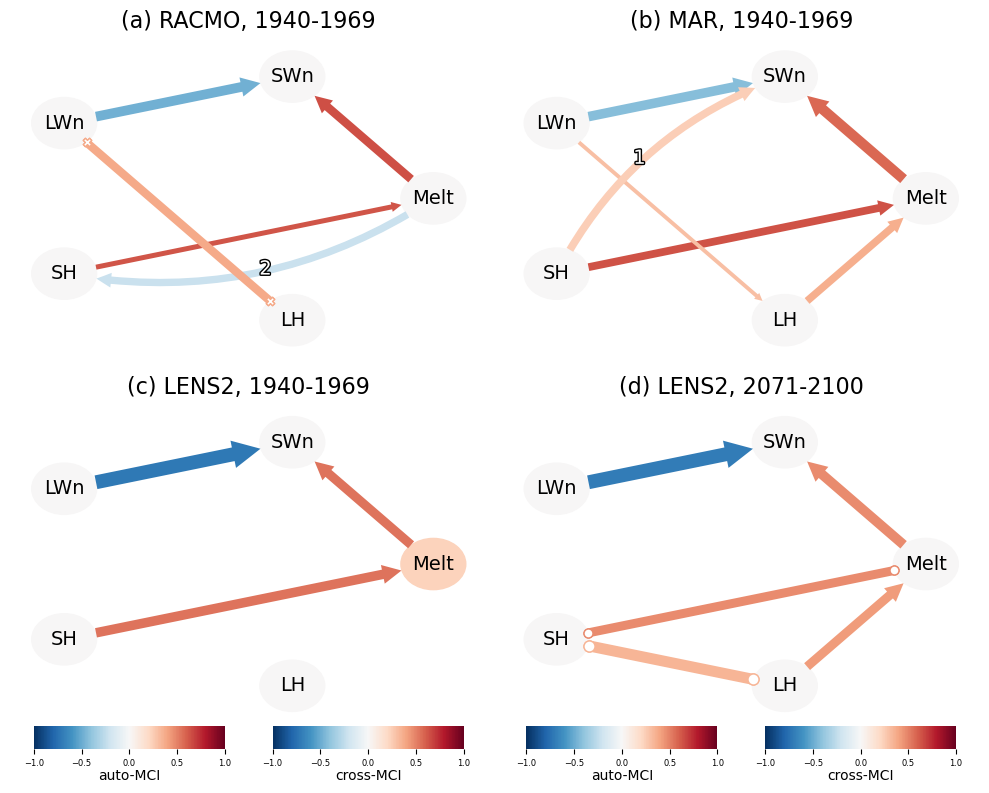

In [54]:
##
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()  # Flatten to easily index subplots

tp.plot_graph(
    val_matrix=val_matrix_RACMO_his,
    graph=graph_RACMO_his,
    var_names=var_names_RACMO_his,
    link_width=link_width_RACMO_his,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
    show_colorbar=False,
    fig_ax=(fig, axs[0])
)

tp.plot_graph(
    val_matrix=val_matrix_MAR_his,
    graph=graph_MAR_his,
    var_names=var_names_MAR_his,
    link_width=link_width_MAR_his,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    show_colorbar=False,
    fig_ax=(fig, axs[1])
)

tp.plot_graph(
    val_matrix=val_matrix_LENS2_his,
    graph=graph_LENS2_his,
    var_names=var_names_LENS2_his,
    link_width=link_width_LENS2_his,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    show_colorbar=True,
    fig_ax=(fig, axs[2])
)

tp.plot_graph(
    val_matrix=val_matrix_LENS2_end,
    graph=graph_LENS2_end,
    var_names=var_names_LENS2_end,
    link_width=link_width_LENS2_end,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    show_colorbar=True,
    fig_ax=(fig, axs[3])
)

# Add title
size_title = 16
axs[0].set_title("(a) RACMO, 1940-1969", fontsize=size_title)
axs[1].set_title("(b) MAR, 1940-1969", fontsize=size_title)
axs[2].set_title("(c) LENS2, 1940-1969", fontsize=size_title)
axs[3].set_title("(d) LENS2, 2071-2100", fontsize=size_title)

plt.tight_layout()
plot_dir = home_dir+'2023-GrIS-melt-causality/manuscript/'
plt.savefig(plot_dir+'fig2_causal_graph_monthly_1940_1969_conservative_nofdrc_robustparcorr_taumax12_alpha01_nomask.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

### With ablation mask

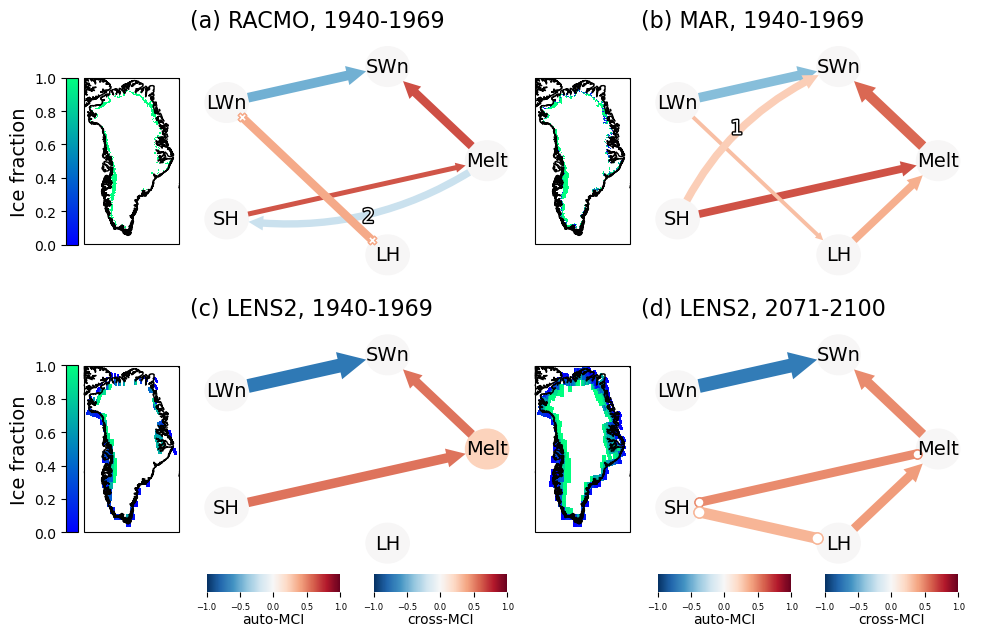

In [56]:
# Create figure and GridSpec
fig = plt.figure(figsize=(11.5, 7))
gs = GridSpec(nrows=2, ncols=4, width_ratios=[1.0, 3.5, 1.0, 3.5], height_ratios=[1, 1], wspace=0.05, hspace=0.15)

# === Causal graph subplots ===
causal_axes = [
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 3]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[1, 3]),
]

# === Map subplots ===
map_axes = [
    fig.add_subplot(gs[0, 0], projection=polar_stereographic),
    fig.add_subplot(gs[0, 2], projection=polar_stereographic),
    fig.add_subplot(gs[1, 0], projection=polar_stereographic),
    fig.add_subplot(gs[1, 2], projection=polar_stereographic),
]

# === Plot causal graphs ===
tp.plot_graph(
    val_matrix=val_matrix_RACMO_his,
    graph=graph_RACMO_his,
    var_names=var_names_RACMO_his,
    link_width=link_width_RACMO_his,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
    show_colorbar=False,
    fig_ax=(fig, causal_axes[0])
)
#causal_axes[0].set_title("Graph A")

tp.plot_graph(
    val_matrix=val_matrix_MAR_his,
    graph=graph_MAR_his,
    var_names=var_names_MAR_his,
    link_width=link_width_MAR_his,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    show_colorbar=False,
    fig_ax=(fig, causal_axes[1])
)
#causal_axes[1].set_title("Graph B")

tp.plot_graph(
    val_matrix=val_matrix_LENS2_his,
    graph=graph_LENS2_his,
    var_names=var_names_LENS2_his,
    link_width=link_width_LENS2_his,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    show_colorbar=True,
    fig_ax=(fig, causal_axes[2])
)
#causal_axes[2].set_title("Graph C")


tp.plot_graph(
    val_matrix=val_matrix_LENS2_end,
    graph=graph_LENS2_end,
    var_names=var_names_LENS2_end,
    link_width=link_width_LENS2_end,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    show_colorbar=True,
    fig_ax=(fig, causal_axes[3])
)
#causal_axes[3].set_title("Graph D")

# === Plot Cartopy maps ===
map_axes[0].set_extent([-56.4, -29.6, 58, 84], crs=ccrs.PlateCarree())
map_axes[0].coastlines(resolution='10m', zorder=7)
im1 = map_axes[0].pcolormesh(racmo_lon, racmo_lat, ablation_mask_RACMO_his, cmap='winter', transform=ccrs.PlateCarree(), vmin=0, vmax=1)
map_axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
map_axes[0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

cbar_ax1 = fig.add_axes([0.11, 0.581, 0.01, 0.2385])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical')
cb1.set_label(label='Ice fraction', size=14)
cb1.ax.tick_params(labelsize=10)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

map_axes[1].set_extent([-56.4, -29.6, 58, 84], crs=ccrs.PlateCarree())
map_axes[1].coastlines(resolution='10m', zorder=7)
im2 = map_axes[1].pcolormesh(mar_lon, mar_lat, ablation_mask_MAR_his, cmap='winter', transform=ccrs.PlateCarree())
map_axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
map_axes[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

map_axes[2].set_extent([-56.4, -29.6, 58, 84], crs=ccrs.PlateCarree())
map_axes[2].coastlines(resolution='10m', zorder=7)
im3 = map_axes[2].pcolormesh(f09_lon, f09_lat, ablation_mask_LENS2_his, cmap='winter', transform=ccrs.PlateCarree())
map_axes[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
map_axes[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

cbar_ax3 = fig.add_axes([0.11, 0.17, 0.01, 0.2385])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical')
cb3.set_label(label='Ice fraction', size=14)
cb3.ax.tick_params(labelsize=10)
cb3.ax.yaxis.set_ticks_position('left')
cb3.ax.yaxis.set_label_position('left')

map_axes[3].set_extent([-56.4, -29.6, 58, 84], crs=ccrs.PlateCarree())
map_axes[3].coastlines(resolution='10m', zorder=7)
im4 = map_axes[3].pcolormesh(f09_lon, f09_lat, ablation_mask_LENS2_end, cmap='winter', transform=ccrs.PlateCarree())
map_axes[3].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
map_axes[3].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Add title
size_title = 16
causal_axes[0].set_title("(a) RACMO, 1940-1969", fontsize=size_title, loc='left')
causal_axes[1].set_title("(b) MAR, 1940-1969", fontsize=size_title, loc='left')
causal_axes[2].set_title("(c) LENS2, 1940-1969", fontsize=size_title, loc='left')
causal_axes[3].set_title("(d) LENS2, 2071-2100", fontsize=size_title, loc='left')


plt.tight_layout()
plot_dir = home_dir+'2023-GrIS-melt-causality/manuscript/'
plt.savefig(plot_dir+'fig2_causal_graph_monthly_1940_1969_conservative_nofdrc_robustparcorr_taumax12_alpha01.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)